****THIS NOTEBOOK WILL HELP IN TESTING OUR MODEL FOR UPSCALING OF LOW RESOLUTION SATELLITE IMAGES****

In [3]:
# Clone SwinIR repo
!git clone https://github.com/JingyunLiang/SwinIR.git

fatal: destination path 'SwinIR' already exists and is not an empty directory.


In [4]:
import sys
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

In [5]:
# Add SwinIR to path
sys.path.append("SwinIR")
from models.network_swinir import SwinIR

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [7]:
MODEL_PATH = "/kaggle/input/best-trained-model/pytorch/default/1/swinir_pretrained (2).pth"

def load_model(model_path, device):
    model = SwinIR(
        upscale=4,
        in_chans=3,
        img_size=48,
        window_size=8,
        img_range=1.0,
        depths=[6, 6, 6, 6, 6, 6],
        embed_dim=180,
        num_heads=[6, 6, 6, 6, 6, 6],
        mlp_ratio=2,
        upsampler="nearest+conv",
        resi_connection="1conv"
    )

    checkpoint = torch.load(model_path, map_location=device)

    if "params_ema" in checkpoint:
        state_dict = checkpoint["params_ema"]
    elif "params" in checkpoint:
        state_dict = checkpoint["params"]
    else:
        state_dict = checkpoint

    
    remove_keys = [k for k in state_dict.keys() if "attn_mask" in k]
    for k in remove_keys:
        del state_dict[k]

    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model

In [8]:
model = load_model(MODEL_PATH, device)
print("✅ Model loaded successfully")

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Model loaded successfully


In [9]:
def preprocess_image(image, target_size=160):
    img = np.array(image)

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)

    img = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_CUBIC)
    img = img.astype(np.float32) / 255.0

    img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0)
    return img_tensor

In [10]:
def postprocess_image(tensor):
    img = tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    return Image.fromarray(img)

In [13]:
@torch.no_grad()
def super_resolve(model, image, device):
    img_tensor = preprocess_image(image).to(device)
    output = model(img_tensor)
    return postprocess_image(output)

****YOU CAN UPLOAD IMAGE AND TEST HERE****

In [14]:
# Example image path (change this)
IMAGE_PATH = "/kaggle/input/delhi-lr/Delhi_LR.jpeg"

lr_image = Image.open(IMAGE_PATH).convert("RGB")
sr_image = super_resolve(model, lr_image, device)

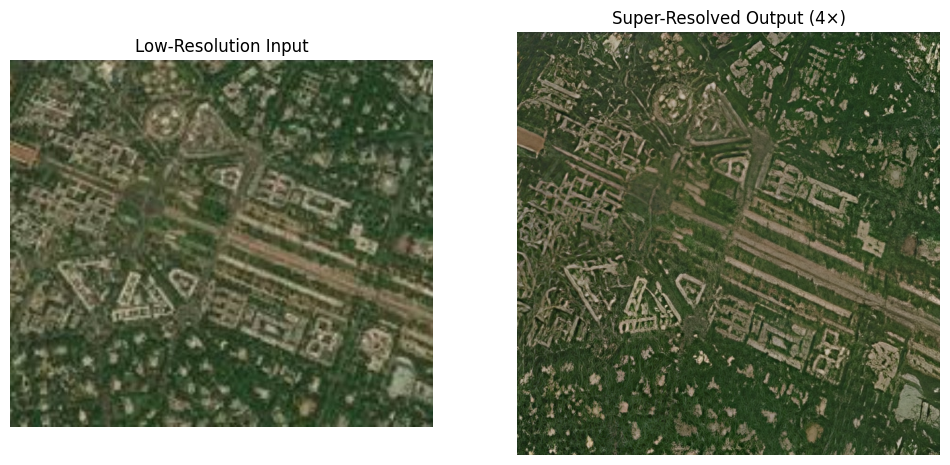

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Low-Resolution Input")
plt.imshow(lr_image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Super-Resolved Output (4×)")
plt.imshow(sr_image)
plt.axis("off")

plt.show()